# House Prices Prediction 

I studied a Kaggle dataset to learn and predict house prices in Ames, Iowa.



https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

In [1]:
import os

import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import scipy.stats
import pylab

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression



## Loading data and Preparation

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.shape

(1460, 81)

In [4]:
## Useless columns are dropped after checking ProfileReport

df = df.drop(['Id', 'Street', 'MiscFeature', 'MiscVal', 'Utilities', 'Condition2', 'RoofMatl', 
              'Heating', 'LowQualFinSF', '3SsnPorch', 'PoolArea', 'PoolQC', 'Street', 
              'GarageCond', 'GarageQual', 'SaleType', 'Alley', 'Functional',
              'BsmtFinType2', 'BsmtCond'], axis = 1)


In [5]:
df['GarageYrBlt'].fillna(df['GarageYrBlt'].median(), inplace=True)

In [6]:
# Age columns are added instead keeping year columns

year_columns = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
for col in year_columns:
    df['Age_'+col] = 2010 - df[col]

df['Months_since_sold'] = 12 * (2011 - df['YrSold']) - df['MoSold']

df = df.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold'], axis = 1)

In [7]:
# Except GarageYrBlt column, I prefer 0 to fill the null values
# Because the null values are mostly belong to categorical columns and
# It means None as a category for these columns.
# Otherwise areas 0 of nonexisting features for observations

df = df.fillna(value = 0)

In [8]:
df.isna().sum().sum()

0

In [9]:
# Object columns are transformed to categorical ones.
# MSSubClass is categorical while the categories are specified with numbers like 20, 30

objects = df.select_dtypes(include='O').columns.to_list()
objects.append('MSSubClass')

for col in objects:
    df[col] = pd.Categorical(df[col])

In [10]:
df.SalePrice.mean()

180921.19589041095

## EDA

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1460.0,57.623288,34.664304,0.0,42.00,63.0,79.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
MasVnrArea,1460.0,103.117123,180.731373,0.0,0.00,0.0,164.25,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0
TotalBsmtSF,1460.0,1057.429452,438.705324,0.0,795.75,991.5,1298.25,6110.0
1stFlrSF,1460.0,1162.626712,386.587738,334.0,882.00,1087.0,1391.25,4692.0


In [12]:
# A detailed profile can be seen by ProfileReport. 
# It's commented because take up too much space on the notebook.

#profile = ProfileReport(df, title = "Report of Houses", html = {'style': {'full_width':True}})

#profile.to_notebook_iframe()

In [13]:
corr_matrix = df.corr().unstack()
corr_matrix[(abs(corr_matrix) > 0.7) & (corr_matrix < 1)]

OverallQual      SalePrice          0.790982
TotalBsmtSF      1stFlrSF           0.819530
1stFlrSF         TotalBsmtSF        0.819530
GrLivArea        TotRmsAbvGrd       0.825489
                 SalePrice          0.708624
TotRmsAbvGrd     GrLivArea          0.825489
GarageCars       GarageArea         0.882475
GarageArea       GarageCars         0.882475
SalePrice        OverallQual        0.790982
                 GrLivArea          0.708624
Age_YearBuilt    Age_GarageYrBlt    0.777182
Age_GarageYrBlt  Age_YearBuilt      0.777182
dtype: float64

In [14]:
corr_matrix['SalePrice'].sort_values()

Age_YearBuilt       -0.522897
Age_YearRemodAdd    -0.507101
Age_GarageYrBlt     -0.466754
KitchenAbvGr        -0.135907
EnclosedPorch       -0.128578
OverallCond         -0.077856
BsmtHalfBath        -0.016844
BsmtFinSF2          -0.011378
Months_since_sold    0.021267
ScreenPorch          0.111447
BedroomAbvGr         0.168213
LotFrontage          0.209624
BsmtUnfSF            0.214479
BsmtFullBath         0.227122
LotArea              0.263843
HalfBath             0.284108
OpenPorchSF          0.315856
2ndFlrSF             0.319334
WoodDeckSF           0.324413
BsmtFinSF1           0.386420
Fireplaces           0.466929
MasVnrArea           0.472614
TotRmsAbvGrd         0.533723
FullBath             0.560664
1stFlrSF             0.605852
TotalBsmtSF          0.613581
GarageArea           0.623431
GarageCars           0.640409
GrLivArea            0.708624
OverallQual          0.790982
SalePrice            1.000000
dtype: float64

The columns with the highest correlation for dependent variable SalePrice are OverallQual, TotalBsmtSF, 1stFlrSF, GrLivArea, GarageCars and GarageArea.

We can see that different kind of areas are correlated to each other. We need to consider to eliminate some of them to satisfy assumptions of multicollinearity for Multiple Linear Regression. However, I believe these columns still help us on the other algorithms.

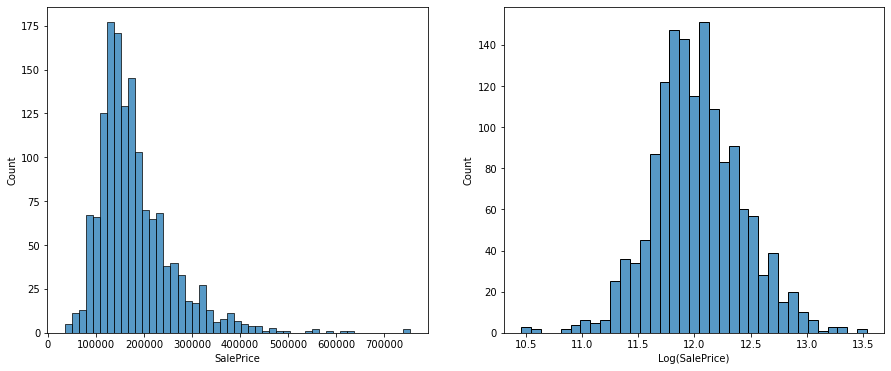

In [15]:
fig = plt.figure(figsize = (15,6))

plt.subplot(1,2,1)
sns.histplot(df.SalePrice)

plt.subplot(1,2,2)
sns.histplot(np.log(df.SalePrice))
plt.xlabel('Log(SalePrice)');

We can see that SalePrice column is right-skewed. After a log transformation, it looks normally distributed. You can see QQPlots of these distributions below.

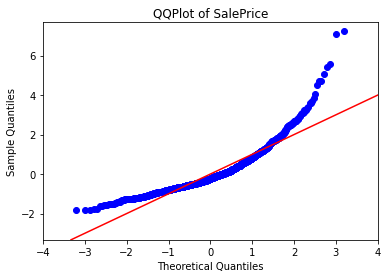

In [16]:
sm.qqplot(scipy.stats.zscore(df.SalePrice), line ='45')
plt.xlim(-4,4)
plt.title('QQPlot of SalePrice');

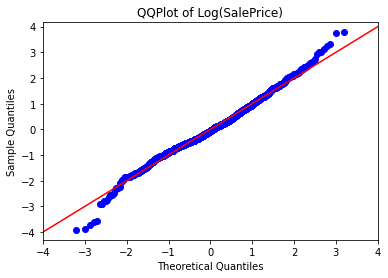

In [17]:
sm.qqplot(scipy.stats.zscore(np.log(df.SalePrice)), line ='45')
plt.xlim(-4,4)
plt.title('QQPlot of Log(SalePrice)');

In [18]:
# Log transformation of the SalePrice column

df['SalePrice'] = np.log(df['SalePrice'])

## Splitting and Feature Engineering

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['SalePrice'], axis=1), df['SalePrice'], 
                                                    test_size=0.20, random_state=12)

In [20]:
# Identify categorical and numerical features
cat_columns = X_train.select_dtypes(include='category').columns.tolist()
num_columns = X_train.select_dtypes(exclude='category').columns.tolist()

# One-hot encoding
X_cat = pd.get_dummies(X_train[cat_columns])

In [21]:
# Transformed numerical features with std_scaler
num_tr = StandardScaler().fit_transform(X_train[num_columns])

In [22]:
num_X = pd.DataFrame(num_tr, columns = num_columns, index = X_train.index)

In [23]:
X_train_ready = pd.concat([num_X, X_cat], axis = 1)

You can find the related preparation function below.

In [24]:
def df_prep(df):
    """
    Categorical and numerical columns are prepared separately.
    One hot encoding for categorical columns and Standard Scaler for numerical columns.
    """
    cat_columns = df.select_dtypes(include='category').columns.tolist()
    num_columns = df.select_dtypes(exclude='category').columns.tolist()

    X_cat = pd.get_dummies(df[cat_columns])
    
    num_tr = StandardScaler().fit_transform(df[num_columns])
       
    num_X = pd.DataFrame(num_tr, columns = num_columns, index = df.index)
    data_ready = pd.concat([num_X, X_cat], axis = 1)
    
    return data_ready

def df_prep_linreg(df):
    cat_columns = df.select_dtypes(include='category').columns.tolist()
    num_columns = df.select_dtypes(exclude='category').columns.tolist()

    X_cat = pd.get_dummies(df[cat_columns])
    
    num_X = df[num_columns]
    data_ready = pd.concat([num_X, X_cat], axis = 1)
    
    return data_ready

### Linear Regression

In [25]:
X_train_linreg = X_train.drop(['1stFlrSF', 'TotalBsmtSF', 'TotRmsAbvGrd', 
                              'GarageArea', 'Age_GarageYrBlt'], axis = 1)

X_train_ready_linreg = df_prep_linreg(X_train_linreg)

X_test_linreg = X_test.drop(['1stFlrSF', 'TotalBsmtSF', 'TotRmsAbvGrd', 
                              'GarageArea', 'Age_GarageYrBlt'], axis = 1)

X_test_ready_linreg = df_prep_linreg(X_test_linreg)

In [26]:
X_train_ready.shape

(1168, 235)

I didn't eliminate insignificant features because there are 235 total columns. However, summary of Multiple Linear Regression can be seen below.

In [27]:
import statsmodels.api as sm

X2 = sm.add_constant(X_train_ready_linreg)
est = sm.OLS(y_train, X2)
est2 = est.fit()
# print(est2.summary())

In [28]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression().fit(X_train_ready_linreg, y_train)

In [29]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(X_train_ready_linreg)
lin_mse = mean_squared_error(np.exp(y_train), np.exp(housing_predictions))
lin_rmse = np.sqrt(lin_mse) # RMSE
lin_rmse

# lin_mse = mean_squared_error(y_train, housing_predictions)

22250.66148214926

In [30]:
housing_predictions2 = lin_reg.predict(X_test_ready_linreg)
lin_mse2 = mean_squared_error(np.exp(y_test), np.exp(housing_predictions2))
lin_rmse2 = np.sqrt(lin_mse2)
lin_rmse2

#lin_mse2 = mean_squared_error(y_test, housing_predictions2)

37684.695835695384

In [31]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

lin_scores = cross_val_score(lin_reg, X_train_ready_linreg, y_train,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [0.269585   0.10759156 0.12209232 0.15677684 0.14026287 0.10162798
 0.12644326 0.16748912 0.15263678 0.12481267]
Mean: 0.14693183851379205
Standard deviation: 0.045570257878161345


In [32]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

## KNN

In [33]:
from sklearn.neighbors import KNeighborsRegressor

X_train_ready = df_prep(X_train)
X_test_ready = df_prep(X_test)

knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_ready, y_train)

KNeighborsRegressor()

In [34]:
print(knn_reg.predict(X_train_ready))

[11.32072889 12.57368804 11.50910699 ... 12.03077253 11.99651364
 12.10128509]


In [35]:
housing_predictions = knn_reg.predict(X_train_ready)
knn_mse = mean_squared_error(np.exp(y_train), np.exp(housing_predictions))
knn_rmse = np.sqrt(knn_mse)
knn_rmse

30259.078390758958

In [36]:
housing_predictions2 = knn_reg.predict(X_test_ready)
knn_mse = mean_squared_error(np.exp(y_test), np.exp(housing_predictions2))
knn_rmse = np.sqrt(knn_mse)
knn_rmse

42272.80902913892

In [41]:
from sklearn.model_selection import GridSearchCV
import time
start_time = time.time()

param_grid = [
    # try 12 (3×4) combinations of G
    {'n_neighbors': np.arange(2, 100, 1), 'weights': ['uniform', 'distance']},
  ]

knn_reg = KNeighborsRegressor()
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(knn_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train_ready, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [42]:
print("--- %s seconds ---" % (time.time() - start_time))
grid_search.best_params_

--- 485.94114446640015 seconds ---


{'n_neighbors': 9, 'weights': 'distance'}

In [42]:
knn_reg = KNeighborsRegressor(n_neighbors = 9, weights = 'distance')
knn_reg.fit(X_train_ready, y_train)

housing_predictions = knn_reg.predict(X_train_ready)
knn_mse = mean_squared_error(np.exp(y_train), np.exp(housing_predictions))
knn_rmse = np.sqrt(knn_mse)
print('Prediction on training: ', knn_rmse)

housing_predictions2 = knn_reg.predict(X_test_ready)
knn_mse = mean_squared_error(np.exp(y_test), np.exp(housing_predictions2))
knn_rmse = np.sqrt(knn_mse)
print('Prediction on test: ', knn_rmse)

Prediction on training:  0.0
Prediction on test:  39413.68016947506


In [43]:
knn_reg = KNeighborsRegressor(n_neighbors = 9, weights = 'uniform')
knn_reg.fit(X_train_ready, y_train)

housing_predictions = knn_reg.predict(X_train_ready)
knn_mse = mean_squared_error(np.exp(y_train), np.exp(housing_predictions))
knn_rmse = np.sqrt(knn_mse)
print('Prediction on training: ', knn_rmse)

housing_predictions2 = knn_reg.predict(X_test_ready)
knn_mse = mean_squared_error(np.exp(y_test), np.exp(housing_predictions2))
knn_rmse = np.sqrt(knn_mse)
print('Prediction on test: ', knn_rmse)

Prediction on training:  32258.444271407287
Prediction on test:  39480.0431249116


### Decision Tree Regressor

In [34]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [34]:
conda install python-graphviz


Note: you may need to restart the kernel to use updated packages.


usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: python-graphviz


In [44]:
from sklearn.tree import DecisionTreeRegressor
from graphviz import Source
from sklearn.tree import export_graphviz
from sklearn import tree

X_train_ready = df_prep(X_train)
X_test_ready = df_prep(X_test)

tree_reg = DecisionTreeRegressor(random_state=42, max_depth=10)
tree_reg.fit(X_train_ready, y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

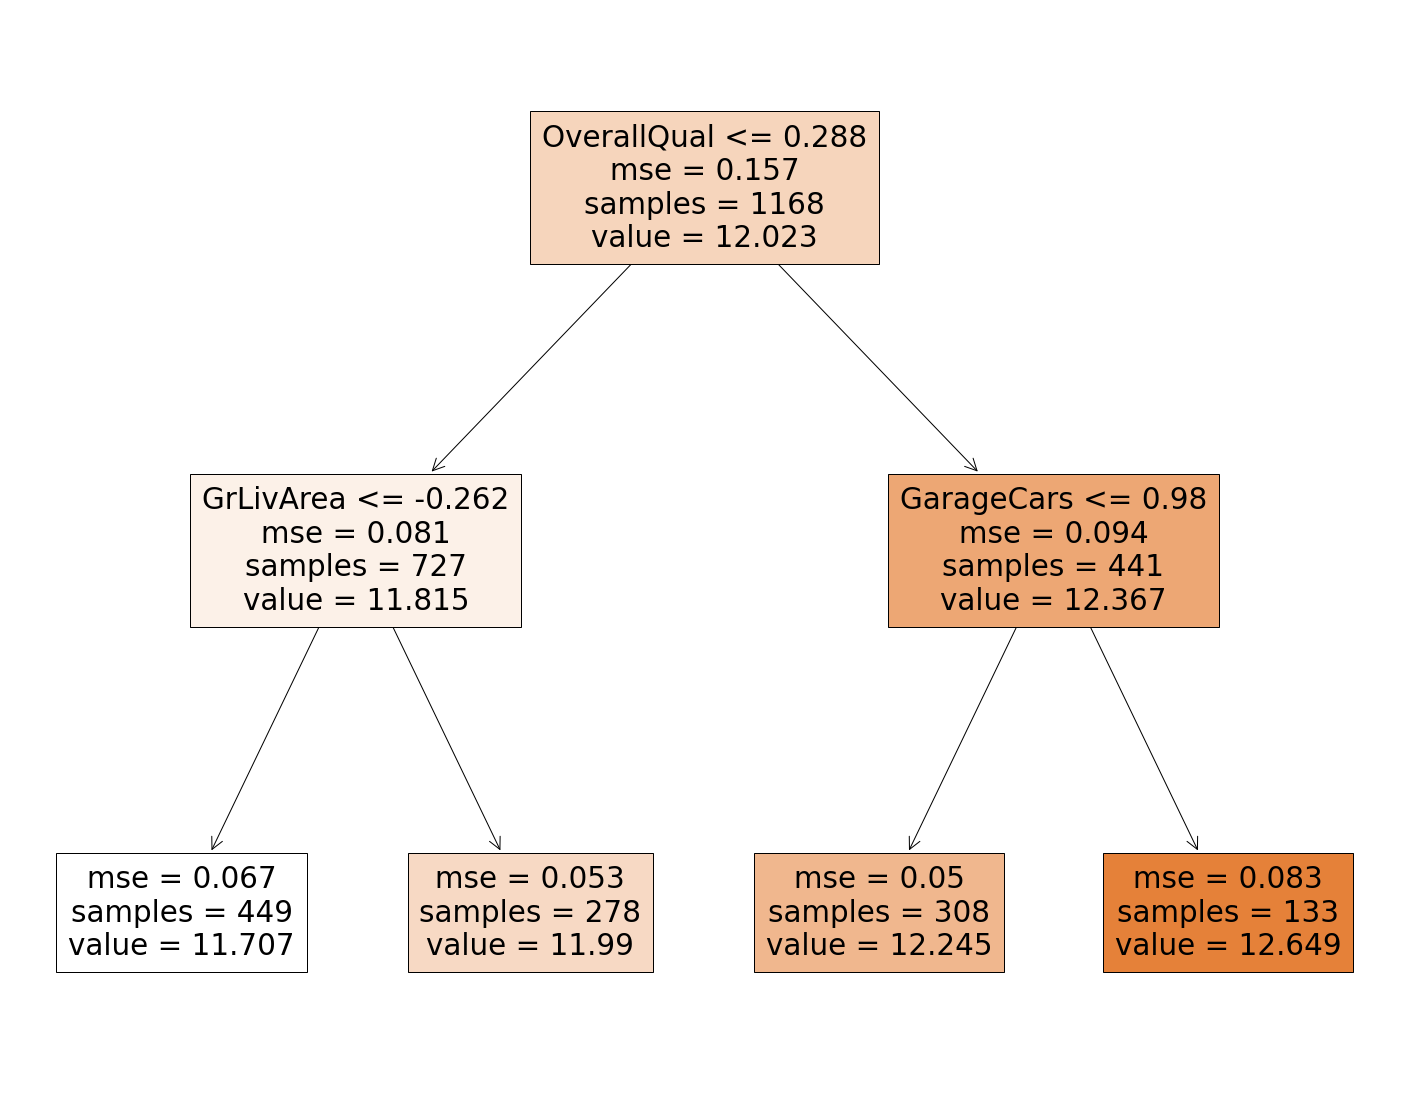

In [45]:
tree_reg = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg.fit(X_train_ready, y_train)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_reg, 
                   feature_names=X_train_ready.columns,
                   filled=True)

In [46]:
housing_predictions = tree_reg.predict(X_train_ready)
tree_mse = mean_squared_error(np.exp(y_train), np.exp(housing_predictions))
tree_rmse = np.sqrt(tree_mse)
tree_rmse

49613.43072754153

In [47]:
housing_predictions2 = tree_reg.predict(X_test_ready)
tree_mse = mean_squared_error(np.exp(y_test), np.exp(housing_predictions2))
tree_rmse2 = np.sqrt(tree_mse)
tree_rmse2

50481.605520160854

In [48]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, X_train_ready, y_train, 
                         scoring='neg_mean_absolute_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [49]:
display_scores(tree_rmse_scores)

Scores: [0.46109825 0.44237755 0.44250813 0.44969152 0.42820239 0.42654716
 0.44262667 0.45855259 0.44593019 0.4454377 ]
Mean: 0.4442972153790672
Standard deviation: 0.010499240780369883


In [60]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'max_depth': np.arange(2, 20, 1), 'min_samples_split': np.arange(2, 100, 3), 
     'max_features' : np.arange(2, 100, 3)},
  ]

grid_search = GridSearchCV(tree_reg, param_grid, cv=10,
                           scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_ready, y_train)

GridSearchCV(cv=10,
             estimator=DecisionTreeRegressor(max_depth=11, max_features=98,
                                             min_samples_split=38,
                                             random_state=42),
             n_jobs=-1,
             param_grid=[{'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                          'max_features': array([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50,
       53, 56, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89, 92, 95, 98]),
                          'min_samples_split': array([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50,
       53, 56, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89, 92, 95, 98])}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [61]:
grid_search.best_params_

{'max_depth': 10, 'max_features': 86, 'min_samples_split': 26}

In [50]:
tree_reg = DecisionTreeRegressor(random_state=42, max_depth=11, max_features=86, min_samples_split=26)
tree_reg.fit(X_train_ready, y_train)

housing_predictions = tree_reg.predict(X_train_ready)
tree_mse = mean_squared_error(np.exp(y_train), np.exp(housing_predictions))
tree_rmse = np.sqrt(tree_mse)
tree_rmse

27527.52615569168

In [51]:
housing_predictions2 = tree_reg.predict(X_test_ready)
tree_mse = mean_squared_error(np.exp(y_test), np.exp(housing_predictions2))
tree_rmse2 = np.sqrt(tree_mse)
tree_rmse2

43000.49953317386

### Random Forest

In [52]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=20, max_features=15, random_state=42)
forest_reg.fit(X_train_ready, y_train)

RandomForestRegressor(max_features=15, n_estimators=20, random_state=42)

In [53]:
housing_predictions = forest_reg.predict(X_train_ready)
forest_mse = mean_squared_error(np.exp(y_train), np.exp(housing_predictions))
forest_rmse = np.sqrt(forest_mse)
forest_rmse

13635.537923023925

In [54]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, X_train_ready, y_train,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.19697562 0.11881191 0.13206889 0.13942015 0.15419075 0.1239211
 0.14288988 0.17143107 0.17837621 0.12663787]
Mean: 0.1484723445260546
Standard deviation: 0.024795244251076348


In [55]:
housing_predictions2 = forest_reg.predict(X_test_ready)
forest_mse = mean_squared_error(np.exp(y_test), np.exp(housing_predictions2))
forest_rmse2 = np.sqrt(forest_mse)
forest_rmse2

31057.797210325225

In [79]:
from sklearn.model_selection import GridSearchCV
import time
start_time = time.time()

param_grid = [
    # try 12 (3×4) combinations of G
    {'n_estimators': np.arange(5, 100, 1), 'max_features': np.arange(3, 30, 1)},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train_ready, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                          'n_estimators': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [81]:
print("--- %s seconds ---" % (time.time() - start_time))
grid_search.best_params_

--- 2387.907384157181 seconds ---


{'max_features': 27, 'n_estimators': 63}

In [103]:
forest_reg = RandomForestRegressor(n_estimators=63, max_features=27, random_state=42, oob_score=True)
forest_reg.fit(X_train_ready, y_train)

housing_predictions = forest_reg.predict(X_train_ready)
forest_mse = mean_squared_error(np.exp(y_train), np.exp(housing_predictions))
forest_rmse = np.sqrt(forest_mse)
forest_rmse

11797.708426971161

In [85]:
feature_importance_df = pd.DataFrame({'Feature': list(X_train_ready.columns), 'Importance': forest_reg.feature_importances_})
print(feature_importance_df.shape)
feature_importance_df.sort_values('Importance', ascending = False).iloc[:150, 1].sum()

(235, 2)


0.9882660404402556

In [84]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train_ready, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000017EBEF26BE0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000017EBEF26130>},
                   random_state=42, scoring='neg_mean_squared_error')

In [85]:
rnd_search.best_estimator_

RandomForestRegressor(max_features=7, n_estimators=180, random_state=42)

In [86]:
forest_reg = RandomForestRegressor(n_estimators=180, max_features=7, random_state=42)
forest_reg.fit(X_train_ready, y_train)

housing_predictions = forest_reg.predict(X_train_ready)
forest_mse = mean_squared_error(np.exp(y_train), np.exp(housing_predictions))
forest_rmse = np.sqrt(forest_mse)
forest_rmse

13359.737062975924

In [87]:
housing_predictions2 = forest_reg.predict(X_test_ready)
forest_mse = mean_squared_error(np.exp(y_test), np.exp(housing_predictions2))
forest_rmse2 = np.sqrt(forest_mse)
forest_rmse2

32966.72470557163

In [50]:
#feature_importances = grid_search.best_estimator_.feature_importances_
#feature_importances

### Adaboost

In [88]:
from sklearn.ensemble import AdaBoostRegressor

# Fit regression model
AdaB_reg = AdaBoostRegressor(DecisionTreeRegressor(random_state=12))

AdaB_reg.fit(X_train_ready, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=12))

In [89]:
housing_predictions = AdaB_reg.predict(X_train_ready)
AdaB_mse = mean_squared_error(np.exp(y_train), np.exp(housing_predictions))
AdaB_rmse = np.sqrt(AdaB_mse)
AdaB_rmse

1006.9166595337381

In [90]:
housing_predictions2 = AdaB_reg.predict(X_test_ready)
AdaB_mse = mean_squared_error(np.exp(y_test), np.exp(housing_predictions2))
AdaB_rmse2 = np.sqrt(AdaB_mse)
AdaB_rmse2

34485.329552470066

In [54]:
param_grid = [
    {'n_estimators': np.arange(20, 500, 20),
 'learning_rate' : np.arange(0.1, 1.1, 0.1),
 'loss' : ['linear', 'square', 'exponential']},
  ]

grid_search = GridSearchCV(AdaB_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_ready, y_train)

grid_search.best_estimator_

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=11,
                                                       max_features=71,
                                                       min_samples_split=35),
                  learning_rate=0.30000000000000004, loss='exponential',
                  n_estimators=460, random_state=1)

In [70]:
AdaB_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=11, max_features=71,  
                        min_samples_split=35), loss='exponential', learning_rate=0.3, n_estimators=460, random_state=1)

AdaB_reg.fit(X_train_ready, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=11,
                                                       max_features=71,
                                                       min_samples_split=35),
                  learning_rate=0.3, loss='exponential', n_estimators=460,
                  random_state=1)

In [91]:
housing_predictions = AdaB_reg.predict(X_train_ready)
AdaB_mse = mean_squared_error(np.exp(y_train), np.exp(housing_predictions))
AdaB_rmse = np.sqrt(AdaB_mse)
AdaB_rmse

1006.9166595337381

In [92]:
housing_predictions2 = AdaB_reg.predict(X_test_ready)
AdaB_mse = mean_squared_error(np.exp(y_test), np.exp(housing_predictions2))
AdaB_rmse2 = np.sqrt(AdaB_mse)
AdaB_rmse2

34485.329552470066

In [58]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
 'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }

pre_gs_inst = RandomizedSearchCV(AdaB_reg,
 param_distributions = param_dist,
 cv=3,
 n_iter = 10,
 n_jobs=-1)

pre_gs_inst.fit(X_train_ready, y_train)

pre_gs_inst.best_estimator_

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=11,
                                                       max_features=71,
                                                       min_samples_split=35),
                  learning_rate=1, loss='square', n_estimators=250,
                  random_state=1)

### Gradient Boosting

In [93]:
from sklearn.ensemble import GradientBoostingRegressor

GradB_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
         max_depth=1, random_state=42, loss='ls')

GradB_reg.fit(X_train_ready, y_train)

GradientBoostingRegressor(max_depth=1, random_state=42)

In [94]:
housing_predictions = GradB_reg.predict(X_train_ready)
GradB_mse = mean_squared_error(np.exp(y_train), np.exp(housing_predictions))
GradB_rmse = np.sqrt(GradB_mse)
GradB_rmse

29680.684485319

In [95]:
housing_predictions2 = GradB_reg.predict(X_test_ready)
GradB_mse = mean_squared_error(np.exp(y_test), np.exp(housing_predictions2))
GradB_rmse2 = np.sqrt(GradB_mse)
GradB_rmse2

32823.202744147304

In [97]:
from sklearn.model_selection import GridSearchCV
import time
start_time = time.time()

# param_grid = [
#     {'n_estimators': np.arange(20, 600, 30),
#  'learning_rate' : np.arange(0.05, 0.16, 0.05),
#  'max_depth' : np.arange(1, 20, 1)},
#   ]

param_grid = [
    {'n_estimators': np.arange(200, 690, 50),
 'learning_rate' : np.arange(0.05, 0.16, 0.05),
 'max_depth' : np.arange(8, 20, 1)},
  ]

grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42, loss='ls'), param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True, n_jobs=10)
grid_search.fit(X_train_ready, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
grid_search.best_estimator_

--- 4333.965736627579 seconds ---


GradientBoostingRegressor(learning_rate=0.05, max_depth=8, n_estimators=650,
                          random_state=42)

In [99]:
GradB_reg = GradientBoostingRegressor(n_estimators=650, learning_rate=0.05,
         max_depth=8, random_state=42, loss='ls')

GradB_reg.fit(X_train_ready, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=8, n_estimators=650,
                          random_state=42)

In [100]:
housing_predictions = GradB_reg.predict(X_train_ready)
GradB_mse = mean_squared_error(np.exp(y_train), np.exp(housing_predictions))
GradB_rmse = np.sqrt(GradB_mse)
GradB_rmse

58.24656469796583

In [101]:
housing_predictions2 = GradB_reg.predict(X_test_ready)
GradB_mse = mean_squared_error(np.exp(y_test), np.exp(housing_predictions2))
GradB_rmse2 = np.sqrt(GradB_mse)
GradB_rmse2

29993.57639037972

## XGBoost

In [56]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [109]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [110]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train_ready, y_train)
    
    housing_predictions = xgb_reg.predict(X_train_ready)
    xgb_mse = mean_squared_error(np.exp(y_train), np.exp(housing_predictions))
    xgb_rmse = np.sqrt(xgb_mse)
    print(xgb_rmse)

1339.0382137698948


In [111]:
housing_predictions2 = xgb_reg.predict(X_test_ready)
xgb_mse = mean_squared_error(np.exp(y_test), np.exp(housing_predictions2))
xgb_rmse2 = np.sqrt(xgb_mse)
xgb_rmse2

32650.800813507263

In [76]:
from sklearn.model_selection import GridSearchCV
import time
start_time = time.time()

param_grid = [
    {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [.01, .03, 0.05, .07], #so called `eta` value
              'max_depth': np.arange(1, 10, 1),
              #'min_child_weight': [4],
              #'subsample': [0.7],
              #'colsample_bytree': [0.7],
              'n_estimators': np.arange(20, 400, 20)}
  ]

xgb_reg = xgboost.XGBRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(xgb_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train_ready, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             param_grid=[{'learning_rate': [0.01, 0.03, 0.05, 0

In [77]:
print("--- %s seconds ---" % (time.time() - start_time))
grid_search.best_params_

--- 3036.322372674942 seconds ---


{'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 380, 'nthread': 4}

In [120]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(learning_rate= 0.07, max_depth= 3, n_estimators= 380, random_state=42, nthread = 4)
    xgb_reg.fit(X_train_ready, y_train)
    
    housing_predictions = xgb_reg.predict(X_train_ready)
    xgb_mse = mean_squared_error(np.exp(y_train), np.exp(housing_predictions))
    xgb_rmse = np.sqrt(xgb_mse)
    print(xgb_rmse)

10217.524799211764


In [121]:
housing_predictions2 = xgb_reg.predict(X_test_ready)
xgb_mse = mean_squared_error(np.exp(y_test), np.exp(housing_predictions2))
xgb_rmse2 = np.sqrt(xgb_mse)
xgb_rmse2

31465.790113298626

## Voting Regressor

In [131]:
from sklearn.ensemble import VotingRegressor

ereg = VotingRegressor(estimators=[('knn', knn_reg), ('rf', forest_reg), ('AB', AdaB_reg), ('GB', GradB_reg), ('XGB', xgb_reg)],
                      weights = [0.1, 0.1, 0.1, 0.6, 0.1])
ereg = ereg.fit(X_train_ready, y_train)

In [132]:
housing_predictions_final = ereg.predict(X_train_ready)
ereg_mse = mean_squared_error(np.exp(y_train), np.exp(housing_predictions_final))
ereg_rmse = np.sqrt(ereg_mse)
ereg_rmse

5230.353868250943

In [133]:
housing_predictions_final2 = ereg.predict(X_test_ready)
ereg_mse = mean_squared_error(np.exp(y_test), np.exp(housing_predictions_final2))
ereg_rmse2 = np.sqrt(ereg_mse)
ereg_rmse2

29759.780666899173

## Stacking

In [134]:
from sklearn.ensemble import StackingRegressor

In [135]:
sreg = StackingRegressor(estimators=[('knn', knn_reg), ('rf', forest_reg), ('AB', AdaB_reg), ('GB', GradB_reg), ('XGB', xgb_reg)])
sreg = sreg.fit(X_train_ready, y_train)

In [136]:
housing_predictions_final = sreg.predict(X_train_ready)
sreg_mse = mean_squared_error(np.exp(y_train), np.exp(housing_predictions_final))
sreg_rmse = np.sqrt(sreg_mse)
sreg_rmse

8971.594700107737

In [137]:
housing_predictions_final2 = sreg.predict(X_test_ready)
sreg_mse = mean_squared_error(np.exp(y_test), np.exp(housing_predictions_final2))
sreg_rmse2 = np.sqrt(sreg_mse)
sreg_rmse2

30930.977915067764

## Final Predictions

In [138]:
test = pd.read_csv("test.csv")

In [139]:
test = test.drop(['Id', 'Street', 'MiscFeature', 'MiscVal', 'Utilities', 'Condition2', 'RoofMatl', 
              'Heating', 'LowQualFinSF', '3SsnPorch', 'PoolArea', 'PoolQC', 'Street', 
              'GarageCond', 'GarageQual', 'SaleType', 'Alley', 'Functional',
              'BsmtFinType2', 'BsmtCond'], axis = 1)

In [140]:
test['GarageYrBlt'].fillna(test['GarageYrBlt'].median(), inplace=True)
year_columns = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
for col in year_columns:
    test['Age_'+col] = 2010 - test[col]

test['Months_since_sold'] = 12 * (2011 - test['YrSold']) - test['MoSold']

test = test.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold'], axis = 1)

In [141]:
test = test.fillna(value = 0)

objects = test.select_dtypes(include='O').columns.to_list()
objects.append('MSSubClass')

for col in objects:
    test[col] = pd.Categorical(test[col])

In [147]:
test_ready.columns[40:50]

Index(['MSSubClass_90', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160',
       'MSSubClass_180', 'MSSubClass_190', 'MSZoning_0', 'MSZoning_C (all)',
       'MSZoning_FV', 'MSZoning_RH'],
      dtype='object')

In [148]:
X_test_ready.columns[40:50]

Index(['MSSubClass_90', 'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180',
       'MSSubClass_190', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM'],
      dtype='object')

In [149]:
test_ready.columns == X_test_ready.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [144]:
test_ready = df_prep(test)

In [145]:
# Adding the missing column

test_ready['Electrical_0'] = 0

In [146]:
final_pred = ereg.predict(test_ready)

ValueError: feature_names mismatch: ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'Age_YearBuilt', 'Age_YearRemodAdd', 'Age_GarageYrBlt', 'Months_since_sold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Other', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'MasVnrType_0', 'MasVnrType_BrkCmn', 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'ExterCond_Ex', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'BsmtQual_0', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtExposure_0', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinType1_0', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'HeatingQC_Ex', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA', 'CentralAir_N', 'CentralAir_Y', 'Electrical_0', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr', 'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'FireplaceQu_0', 'FireplaceQu_Ex', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_Po', 'FireplaceQu_TA', 'GarageType_0', 'GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'GarageFinish_0', 'GarageFinish_Fin', 'GarageFinish_RFn', 'GarageFinish_Unf', 'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y', 'Fence_0', 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal', 'SaleCondition_Partial'] ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'Age_YearBuilt', 'Age_YearRemodAdd', 'Age_GarageYrBlt', 'Months_since_sold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSZoning_0', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'Exterior1st_0', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'Exterior2nd_0', 'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'MasVnrType_0', 'MasVnrType_BrkCmn', 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'ExterCond_Ex', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'BsmtQual_0', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtExposure_0', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinType1_0', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'HeatingQC_Ex', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA', 'CentralAir_N', 'CentralAir_Y', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_SBrkr', 'KitchenQual_0', 'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'FireplaceQu_0', 'FireplaceQu_Ex', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_Po', 'FireplaceQu_TA', 'GarageType_0', 'GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'GarageFinish_0', 'GarageFinish_Fin', 'GarageFinish_RFn', 'GarageFinish_Unf', 'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y', 'Fence_0', 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal', 'SaleCondition_Partial', 'Electrical_0']
expected Exterior1st_ImStucc, Exterior2nd_Other, HouseStyle_2.5Fin, Electrical_Mix, Exterior1st_Stone in input data
training data did not have the following fields: KitchenQual_0, MSZoning_0, Exterior1st_0, Exterior2nd_0, MSSubClass_150

In [ ]:
final_pred = np.exp(final_pred)

In [181]:
test = pd.read_csv("test.csv")

In [185]:
data = {'Id':test['Id'], 'SalePrice':final_pred}

df_submission = pd.DataFrame(data)

In [187]:
df_submission.to_csv(r'Semih_Barutcu_House_Prediction.csv', index = False)

## Final Predictions Stacking

In [193]:
test = pd.read_csv("test.csv")

In [194]:
test = test.drop(['Id', 'Street', 'MiscFeature', 'MiscVal', 'Utilities', 'Condition2', 'RoofMatl', 
              'Heating', 'LowQualFinSF', '3SsnPorch', 'PoolArea', 'PoolQC', 'Street', 
              'GarageCond', 'GarageQual', 'SaleType', 'Alley', 'Functional',
              'BsmtFinType2', 'BsmtCond'], axis = 1)

In [195]:
test['GarageYrBlt'].fillna(test['GarageYrBlt'].median(), inplace=True)
year_columns = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
for col in year_columns:
    test['Age_'+col] = 2010 - test[col]

test['Months_since_sold'] = 12 * (2011 - test['YrSold']) - test['MoSold']

test = test.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold'], axis = 1)

In [196]:
test = test.fillna(value = 0)

objects = test.select_dtypes(include='O').columns.to_list()
objects.append('MSSubClass')

for col in objects:
    test[col] = pd.Categorical(test[col])

In [197]:
test_ready = df_prep(test)

In [198]:
# Adding the missing column

test_ready['Electrical_0'] = 0

In [199]:
final_pred = sreg.predict(test_ready)

ValueError: feature_names mismatch: ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'Age_YearBuilt', 'Age_YearRemodAdd', 'Age_GarageYrBlt', 'Months_since_sold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Other', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'MasVnrType_0', 'MasVnrType_BrkCmn', 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'ExterCond_Ex', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'BsmtQual_0', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtExposure_0', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinType1_0', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'HeatingQC_Ex', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA', 'CentralAir_N', 'CentralAir_Y', 'Electrical_0', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr', 'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'FireplaceQu_0', 'FireplaceQu_Ex', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_Po', 'FireplaceQu_TA', 'GarageType_0', 'GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'GarageFinish_0', 'GarageFinish_Fin', 'GarageFinish_RFn', 'GarageFinish_Unf', 'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y', 'Fence_0', 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal', 'SaleCondition_Partial'] ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'Age_YearBuilt', 'Age_YearRemodAdd', 'Age_GarageYrBlt', 'Months_since_sold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSZoning_0', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'Exterior1st_0', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'Exterior2nd_0', 'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'MasVnrType_0', 'MasVnrType_BrkCmn', 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'ExterCond_Ex', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'BsmtQual_0', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtExposure_0', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinType1_0', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'HeatingQC_Ex', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA', 'CentralAir_N', 'CentralAir_Y', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_SBrkr', 'KitchenQual_0', 'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'FireplaceQu_0', 'FireplaceQu_Ex', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_Po', 'FireplaceQu_TA', 'GarageType_0', 'GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'GarageFinish_0', 'GarageFinish_Fin', 'GarageFinish_RFn', 'GarageFinish_Unf', 'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y', 'Fence_0', 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal', 'SaleCondition_Partial', 'Electrical_0']
expected Exterior1st_ImStucc, HouseStyle_2.5Fin, Exterior1st_Stone, Exterior2nd_Other, Electrical_Mix in input data
training data did not have the following fields: MSZoning_0, KitchenQual_0, Exterior1st_0, MSSubClass_150, Exterior2nd_0

In [200]:
final_pred = np.exp(final_pred)

NameError: name 'final_pred' is not defined

In [90]:
test = pd.read_csv("test.csv")

In [91]:
data = {'Id':test['Id'], 'SalePrice':final_pred}

df_submission = pd.DataFrame(data)

In [92]:
df_submission.to_csv(r'Semih_Barutcu_House_Prediction.csv', index = False)

### Random Forest Pred only

In [51]:
final_pred = forest_reg.predict(test_ready)
final_pred = np.exp(final_pred)
test = pd.read_csv("test.csv")

data = {'Id':test['Id'], 'SalePrice':final_pred}

df_submission2 = pd.DataFrame(data)

df_submission2.to_csv(r'Semih_Barutcu_House_Prediction.csv', index = False)